# Movie recommender system
1. matrix factorization
2. multilayer perceptron

**dataset:** ml-100k

In [1]:
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil
 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
 
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam

## Load dataset

In [2]:
# legge il dataset
dataset = pd.read_csv("ml-100k/u.data", sep='\t', names="user_id,item_id,rating,timestamp".split(","))

# fa partire gli indici da 0 invece che da 1
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

train, test = train_test_split(dataset, test_size=0.2)

# conta il numero di film e utenti unici
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 5
print(f'Number of users: {n_users}      Number of movies: {n_movies}')

Number of users: 943      Number of movies: 1682


In [3]:
# vettore latente film
movie_input = keras.layers.Input(shape=(1,), name='item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='flatten_movie')(movie_embedding)

# vettore latente film
user_input = keras.layers.Input(shape=(1,),name='User')
user_vec = keras.layers.Flatten(name='flatten_user')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='user_embedding')(user_input))

# prodotto scalare
prod = keras.layers.dot([movie_vec, user_vec], axes=1,name='dot_product')
model = keras.Model([user_input, movie_input], prod)

In [4]:
# compila il modello monitorando mean absolute error (MAE) e mean squared error (MSE)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 5)         8415        item[0][0]                       
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 5)         4720        User[0][0]                       
______________________________________________________________________________________________

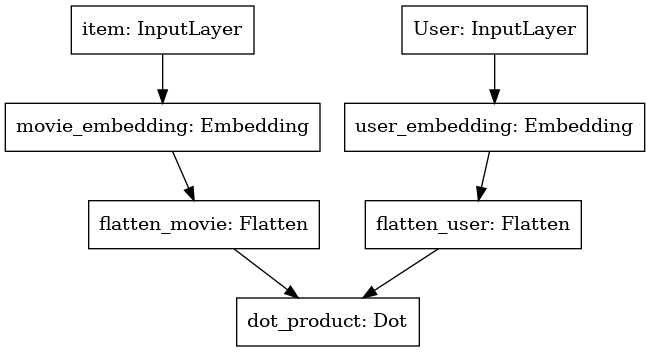

In [9]:
tf.keras.utils.plot_model(model)

In [10]:
# train del modello 
history = model.fit([train.user_id, train.item_id], train.rating, epochs=200, batch_size=128, verbose=1)

625/625 [==============================] - 1s 2ms/step - loss: 0.8552 - mae: 0.7294 - mse: 0.8552
Epoch 23/200
625/625 [==============================] - 2s 2ms/step - loss: 0.8540 - mae: 0.7287 - mse: 0.8540
Epoch 24/200
625/625 [==============================] - 2s 3ms/step - loss: 0.8526 - mae: 0.7281 - mse: 0.8526
Epoch 25/200
625/625 [==============================] - 2s 3ms/step - loss: 0.8517 - mae: 0.7280 - mse: 0.8517
Epoch 26/200
625/625 [==============================] - 2s 2ms/step - loss: 0.8505 - mae: 0.7277 - mse: 0.8505
Epoch 27/200
625/625 [==============================] - 2s 3ms/step - loss: 0.8497 - mae: 0.7271 - mse: 0.8497
Epoch 28/200
625/625 [==============================] - 2s 3ms/step - loss: 0.8485 - mae: 0.7267 - mse: 0.8485
Epoch 29/200
625/625 [==============================] - 4s 6ms/step - loss: 0.8474 - mae: 0.7259 - mse: 0.8474
Epoch 30/200
625/625 [==============================] - 6s 10ms/step - loss: 0.8464 - mae: 0.7256 - mse: 0.8464
Epoch 31/200


Text(0, 0.5, 'Training Error')

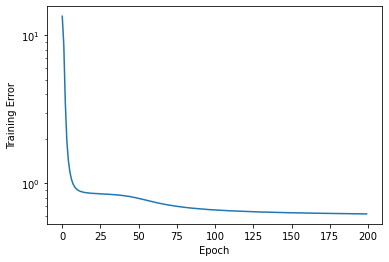

In [13]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [12]:
results = model.evaluate((test.user_id, test.item_id), test.rating, batch_size=1)

20000/20000 [==============================] - 85s 4ms/step - loss: 0.9575 - mae: 0.7519 - mse: 0.9575


In [14]:
# movie embedding
movie_embedding_learnt = model.get_layer(name='movie_embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt)

,0,1,2,3,4
0,-1.002164,-1.297313,0.806395,-0.581879,-0.755434
1,-1.264288,-0.767032,0.711527,-0.443018,-0.518258
2,-1.225812,0.082744,0.598887,-0.100142,-1.795794
3,-0.540931,-1.129386,1.197583,-1.026920,-0.024167
4,-1.271261,-0.833028,0.170629,-0.833080,-0.736995
...,...,...,...,...,...
1678,-0.782293,-0.710115,0.680705,-0.779473,-0.639199
1679,-0.456115,-0.466445,0.500545,-0.531318,-0.328147
1680,-0.828265,-0.840178,0.807994,-0.855479,-0.789276
1681,-0.676024,-0.739343,0.725215,-0.779132,-0.720391


In [15]:
# user embedding
user_embedding_learnt = model.get_layer(name='user_embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt)

,0,1,2,3,4
0,-0.215182,-1.087345,1.401779,-0.867919,-0.884994
1,-0.721350,-0.691849,1.296249,-0.784166,-1.291198
2,-0.987859,0.155875,0.905097,-1.091032,-0.932449
3,-0.982251,-0.454629,1.224923,-2.231773,-0.255070
4,-1.164809,-0.053161,2.110773,-0.498113,0.059856
...,...,...,...,...,...
939,-1.141377,-0.864469,0.561763,-0.749312,-0.712845
940,-0.460163,-1.376372,0.322481,-2.110453,-1.343451
941,-1.274684,-1.033382,0.443511,-0.820614,-1.493900
942,-1.498256,-0.042739,1.617836,-1.707287,0.619539


### Predict top-k and rating

In [16]:

# migliori raccomandazione per un utente user_id
def recommend(user_id, number_of_movies=5):
    # prodotto tra la matrice user_embedding e la trasposta di movie_embedding, si ottengono i rating per l'utente user_id
    movies = user_embedding_learnt[user_id].dot(movie_embedding_learnt.T)

    # l'output di argpartition contiene la posizione che avrebbe un rating se fosse in una lista ordinata, prendendo i primi
    # n valori si ottengono gli id dei migliori film per l'utente.
    # movies_id può essere usato per trovare il rating nella lista dei film
    mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
    return mids

# ritorna un df dei valori reali e predetti per un utente
def predict(user_id):
    df_actual_rating = test[(test['user_id'] == user_id)]
    predicted_rating_list = user_embedding_learnt[user_id].dot(movie_embedding_learnt.T)
    predicted_dict = {k:[] for k in ['item_id', 'actual_rating', 'pred_rating']}
    
    for index, row in df_actual_rating.iterrows():
        movie_id = row['item_id']
        actual_rating = row['rating']
        predicted_rating = predicted_rating_list[movie_id]

        predicted_dict['item_id'].append(movie_id)
        predicted_dict['actual_rating'].append(actual_rating)
        predicted_dict['pred_rating'].append(predicted_rating)
    
    df = pd.DataFrame(predicted_dict)

    return df


In [17]:
user = 377
movie = 800
n_movie_recommended = 10
recommended_id = recommend(user, n_movie_recommended)
recommended_id # lista film consigliati


array([1357, 1449, 1393, 1642, 1535, 1641,  813, 1356, 1499,  112])

In [18]:
predict(user).head(20) # df che contiene rating reali e rating predetti

,item_id,actual_rating,pred_rating
0,327,3,3.167816
1,172,5,3.878302
2,484,4,3.469178
3,67,2,3.113904
4,181,4,3.589193
5,196,3,4.330615
6,1036,2,1.981285
7,743,3,3.844636
8,355,4,3.251974
9,193,4,3.812138


In [19]:
# come trovare rating di un film
movies = user_embedding_learnt[user].dot(movie_embedding_learnt.T)
f"rating for movie {recommended_id[4]}: {movies[recommended_id[4]]}"

'rating for movie 1535: 5.757889747619629'

In [20]:
# movie lookup dataframe
movie_lookup = pd.read_csv("ml-100k/u-utf8.item", sep='|', names="movie_id,movie_title".split(","), usecols=[0,1])
movie_lookup.movie_id = movie_lookup.movie_id.astype('category').cat.codes.values # indici da 0 invece che 1

In [21]:
movie_lookup

,movie_id,movie_title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)
...,...,...
1677,1677,Mat' i syn (1997)
1678,1678,B. Monkey (1998)
1679,1679,Sliding Doors (1998)
1680,1680,You So Crazy (1994)


In [22]:
# converte da id a nomi di film
recommended = movie_lookup[movie_lookup['movie_id'].isin(recommended_id)]
recommended

,movie_id,movie_title
112,112,"Horseman on the Roof, The (Hussard sur le toit..."
813,813,"Great Day in Harlem, A (1994)"
1356,1356,For the Moment (1994)
1357,1357,The Deadly Cure (1996)
1393,1393,Swept from the Sea (1997)
1449,1449,Golden Earrings (1947)
1499,1499,Santa with Muscles (1996)
1535,1535,Aiqing wansui (1994)
1641,1641,Some Mother's Son (1996)
1642,1642,Angel Baby (1995)


## MLP

In [23]:
movie_input = keras.layers.Input(shape=[1],name='item')

# Movie embedding
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='movies_embedding')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='flatten_movies')(movie_embedding_mlp)

# User embedding
user_input = keras.layers.Input(shape=[1],name='user')
user_vec_mlp = keras.layers.Flatten(name='flatten_users')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='users_embedding')(user_input))

# Concat embedding utenti e film
concat = tf.keras.layers.Concatenate(name='users_movies')([movie_vec_mlp, user_vec_mlp])

# layers densi
dense = keras.layers.Dense(20,name='fully_connected_1')(concat)
dense_2 = keras.layers.Dense(10,name='fully_connected_2')(dense)

# Output
pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_2)

# crea e compila il modello
mlp = keras.Model([user_input, movie_input], pred_mlp)
mlp.compile(optimizer='adam',loss= 'mean_absolute_error', metrics=['mae', 'mse'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 5)         8415        item[0][0]                       
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 5)         4720        user[0][0]                       
____________________________________________________________________________________________

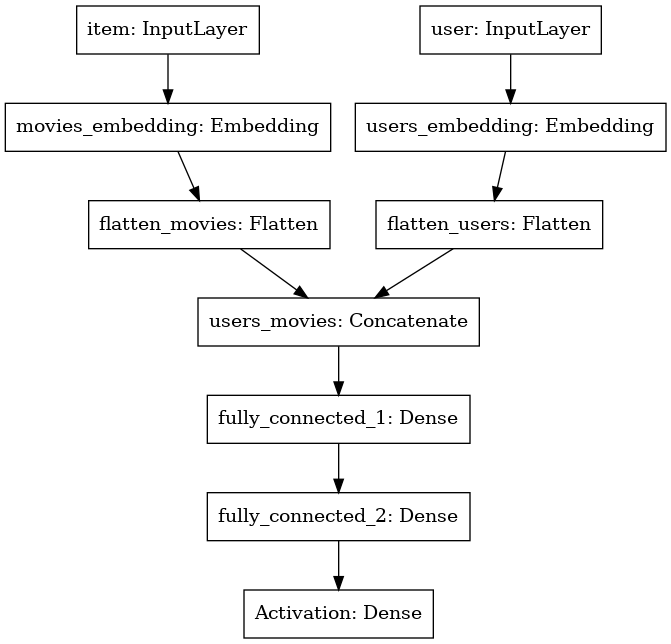

In [24]:
mlp.summary()
tf.keras.utils.plot_model(mlp)

In [25]:
history = mlp.fit([train.user_id, train.item_id], train.rating, epochs = 30, batch_size = 128, verbose = 1)

Epoch 1/30
625/625 [==============================] - 2s 3ms/step - loss: 1.0090 - mae: 1.0090 - mse: 1.9106
Epoch 2/30
625/625 [==============================] - 2s 3ms/step - loss: 0.7379 - mae: 0.7379 - mse: 0.9079
Epoch 3/30
625/625 [==============================] - 2s 3ms/step - loss: 0.7314 - mae: 0.7314 - mse: 0.8965
Epoch 4/30
625/625 [==============================] - 2s 3ms/step - loss: 0.7281 - mae: 0.7281 - mse: 0.8927
Epoch 5/30
625/625 [==============================] - 2s 3ms/step - loss: 0.7263 - mae: 0.7263 - mse: 0.8892
Epoch 6/30
625/625 [==============================] - 2s 3ms/step - loss: 0.7246 - mae: 0.7246 - mse: 0.8874
Epoch 7/30
625/625 [==============================] - 2s 3ms/step - loss: 0.7235 - mae: 0.7235 - mse: 0.8859
Epoch 8/30
625/625 [==============================] - 2s 3ms/step - loss: 0.7230 - mae: 0.7230 - mse: 0.8849
Epoch 9/30
625/625 [==============================] - 2s 3ms/step - loss: 0.7215 - mae: 0.7215 - mse: 0.8840
Epoch 10/30
625/625

In [26]:
 results_mlp = mlp.evaluate((test.user_id, test.item_id), test.rating, batch_size=1)

20000/20000 [==============================] - 86s 4ms/step - loss: 0.7385 - mae: 0.7385 - mse: 0.9159


In [27]:
# predizioni sul test set per un MLP
def predict_mlp():
    predicted_dict = {k:[] for k in ['user_id', 'item_id', 'actual_rating', 'pred_rating']}
    mlp_predicted = mlp.predict([test.user_id, test.item_id])
    test2 = test.reset_index(drop=True)

    for idx, row in test2.iterrows():
        predicted_dict['user_id'].append(row['user_id'])
        predicted_dict['item_id'].append(row['item_id'])
        predicted_dict['actual_rating'].append(row['rating'])
        predicted_dict['pred_rating'].append(mlp_predicted[idx][0])
        
    df = pd.DataFrame(predicted_dict)
    return df

In [28]:
predict_mlp()

,user_id,item_id,actual_rating,pred_rating
0,738,196,1,3.961779
1,416,245,4,4.017724
2,338,216,3,3.367577
3,705,686,1,2.151093
4,906,219,5,4.272842
...,...,...,...,...
19995,604,131,5,4.156857
19996,473,41,4,4.135766
19997,712,341,3,1.998381
19998,217,516,3,3.824699


## NeuMF
Modello che combina MF a MLP

In [55]:
# number of latent factor for MLP and MF
n_latent_factors_user = 8
n_latent_factors_movie = 8
n_latent_factors_mf = 5

# movie embedding MLP
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='movie_embedding_MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='flatten_movie_MLP')(movie_embedding_mlp)

# movie embedding MF
movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='movie_embedding_MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='flatten_movie_MF')(movie_embedding_mf)

# user embedding MLP
user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='flatten_user_MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='user_embedding_MLP')(user_input))

# user embedding MF
user_vec_mf = keras.layers.Flatten(name='flatten_user_MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='user_embedding_MF')(user_input))

# concat movie embedding and user embedding for MLP
concat = keras.layers.Concatenate(name='user_concat_movie')([movie_vec_mlp, user_vec_mlp])

# fully connected layers for MLP
dense_1 = keras.layers.Dense(24,name='fully_connected_1')(concat)
dense_2 = keras.layers.Dense(16,name='fully_connected_2')(dense_1)
dense_3 = keras.layers.Dense(8,name='fully_connected_3')(dense_2)

# MF dot product
dot_mf = keras.layers.dot([movie_vec_mf, user_vec_mf], axes=1,name='dot_product')

# Concatenate MF and MLP
concat_mlp_mf = keras.layers.Concatenate(name='concat_MF_MLP')([dot_mf, dense_3])

# Output layer
result = keras.layers.Dense(1,name='output')(concat_mlp_mf)

In [56]:
neumf = keras.Model([user_input, movie_input], result)
neumf.compile(optimizer='adam',loss= 'mean_absolute_error', metrics=['mae', 'mse'])
neumf.summary()


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding_MLP (Embedding) (None, 1, 8)         13464       Item[0][0]                       
__________________________________________________________________________________________________
user_embedding_MLP (Embedding)  (None, 1, 8)         7552        User[0][0]                       
___________________________________________________________________________________________

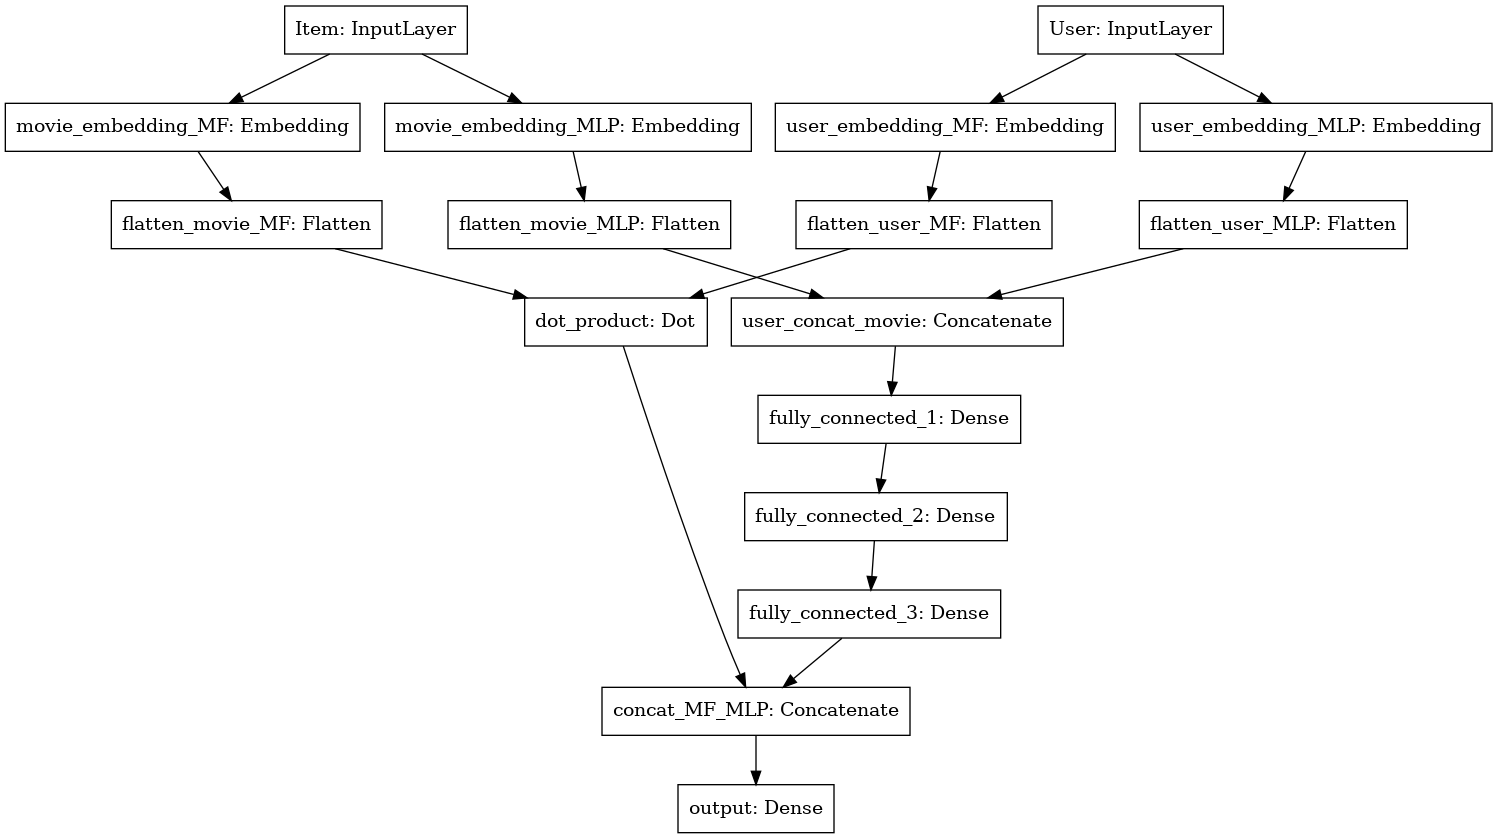

In [57]:
tf.keras.utils.plot_model(neumf)

In [51]:
neumf.fit([train.user_id, train.item_id], train.rating, epochs=10, verbose=1)

Epoch 1/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.8212 - mae: 0.8212 - mse: 1.1575
Epoch 2/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.7409 - mae: 0.7409 - mse: 0.9127
Epoch 3/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7150 - mae: 0.7150 - mse: 0.8642
Epoch 4/10
2500/2500 [==============================] - 11s 5ms/step - loss: 0.6953 - mae: 0.6953 - mse: 0.8287
Epoch 5/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.6842 - mae: 0.6842 - mse: 0.8084
Epoch 6/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.6750 - mae: 0.6750 - mse: 0.7923
Epoch 7/10
2500/2500 [==============================] - 11s 5ms/step - loss: 0.6683 - mae: 0.6683 - mse: 0.7819
Epoch 8/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.6630 - mae: 0.6630 - mse: 0.7734
Epoch 9/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.6586 - mae: 0.6586 - mse: 

In [53]:
 results_neumf = neumf.evaluate((test.user_id, test.item_id), test.rating, batch_size=1)

20000/20000 [==============================] - 56s 3ms/step - loss: 0.7520 - mae: 0.7520 - mse: 0.9489
